In [21]:
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
from matplotlib import pyplot as plt
from pylab import rcParams
import sklearn
from sklearn.linear_model import LinearRegression
import talib
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MaxAbsScaler
import time
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.metrics import *
import os
import tensorflow as tf
import tensorflow_addons as tfa 
from sklearn.preprocessing import OneHotEncoder

In [22]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

np.random.seed(42)
tf.random.set_seed(42)

<h1 style="font-size:40px;"> <center> FUNCTIONS </center> </h1>

In [23]:
def HMA(df:pd.DataFrame, timeperiod:int= 14) -> float:
    """
    Hull Moving Average.
    Formula:
    HMA = WMA(2*WMA(n/2) - WMA(n)), sqrt(n)
    """
    hma = talib.WMA(2 * talib.WMA(df, int(timeperiod/2)) - talib.WMA(df, timeperiod), int(np.sqrt(timeperiod)))
    return hma


def money_flow_volume_series(df: pd.DataFrame) -> pd.Series:
    """
    Calculates money flow series
    """
    mfv = df['Volume'] * (2*df['Close'] - df['High'] - df['Low']) / \
                                    (df['High'] - df['Low'])
    return mfv


def money_flow_volume(df: pd.DataFrame, timeperiod: int=20) -> pd.Series:
    """
    Calculates money flow volume, or q_t in our formula
    """
    return money_flow_volume_series(df).rolling(timeperiod).sum()


def CMF(df: pd.DataFrame, timeperiod: int=20) -> pd.Series:
    """
    Calculates the Chaikin money flow
    """
    return money_flow_volume(df, timeperiod) / df['Volume'].rolling(timeperiod).sum()


def pltcolor(lst:list) -> list:
    cols=[]
    for i in range(lst.shape[0]):
        if lst.iloc[i] == 1:
            cols.append('green')
        elif lst.iloc[i] == 2:
            cols.append('red')
    return cols


def adjustPrices(df:pd.DataFrame) -> None:
    adjustedRatio = df["Adj Close"]/df["Close"]
    df["High"] = df["High"] * adjustedRatio
    df["Low"] = df["Low"] * adjustedRatio
    df["Open"] = df["Open"] * adjustedRatio
    df["Close"] = df["Close"] * adjustedRatio   
    

def trendNormalizePrices(prices:pd.DataFrame) -> None:
    df = prices.copy()
    df["rowNumber"] = list(range(len(df)))
    df["TN_Open"] = list(range(len(df)))
    df["TN_High"] = list(range(len(df)))
    df["TN_Low"] = list(range(len(df)))
    df["TN_Close"] = list(range(len(df)))
    for i in range(29,len(df)):
        model = LinearRegression()
        model.fit(np.array(df["rowNumber"].iloc[i-29:i+1]).reshape(-1,1), np.array(df["Close"].iloc[i-29:i+1]))
        prediction = model.predict(np.array([df["rowNumber"].iloc[i]]).reshape(-1,1))
        df.iloc[i, df.columns.get_loc("TN_Open")] = df["Open"].iloc[i] - prediction 
        df.iloc[i, df.columns.get_loc("TN_High")] = df["High"].iloc[i] - prediction 
        df.iloc[i, df.columns.get_loc("TN_Low")] = df["Low"].iloc[i] - prediction 
        df.iloc[i, df.columns.get_loc("TN_Close")] = df["Close"].iloc[i] - prediction 
    df["Open"] = df["TN_Open"] 
    df["High"] = df["TN_High"]
    df["Low"] = df["TN_Low"]
    df["Close"] = df["TN_Close"]
    df = df.drop(index=df.index[:30], axis=0)
    df = df.drop(columns=["TN_Open", "TN_High", "TN_Low", "TN_Close", "rowNumber"], axis=1)
    return df
    
    
def create_labels(prices:pd.DataFrame) -> None:
    df = prices.copy()
    df["Label"] = [0] * df.shape[0]
    for i in range(df.shape[0]-10):
        s = set(df["Close"].iloc[i:i+11]) 
        minPrice = sorted(s)[0]
        maxPrice = sorted(s)[-1]
        for j in range(i, i+11):
            if df["Close"].iloc[j] == minPrice and (j-i) == 5:
                df.iloc[j, df.columns.get_loc('Label')] = 1
            elif df["Close"].iloc[j] == maxPrice and (j-i) == 5:
                df.iloc[j, df.columns.get_loc('Label')] = 2
    return df.iloc[6:-6]
                
                
def reverse_one_hot(predictions:np.array) -> np.array:
    return np.argmax(predictions, axis=1)


def one_hot(predictions:np.array) -> np.array:
    predictions_one_hot = []
    for i in predictions:
        prediction = [0,0,0]
        prediction[int(i)] = 1
        predictions_one_hot.append(prediction)   
    return np.array(predictions_one_hot)


def number_null_and_nan(df:pd.DataFrame) -> int:
    na = pd.isna(df).sum().sum()
    null = df.isnull().sum().sum()
    return (na+null) 

<h1 style="font-size:40px;"> <center> DATA PREPROCESSING </center> </h1>

In [24]:
prices = yf.download("SPY", start="2009-09-20", end="2023-01-01", interval="1d", progress=False, auto_adjust=True)
prices

,Open,High,Low,Close,Volume
Date,,,,,
2009-09-21 00:00:00-04:00,82.204712,83.066429,82.026161,82.639450,151892000
2009-09-22 00:00:00-04:00,83.128523,83.353657,82.755886,83.120758,143126700
2009-09-23 00:00:00-04:00,83.314846,83.866034,82.282337,82.429840,225947400
2009-09-24 00:00:00-04:00,82.608389,82.786940,81.164431,81.521538,228636800
2009-09-25 00:00:00-04:00,81.342987,81.793255,80.807323,81.086800,204059000
...,...,...,...,...,...
2022-12-23 00:00:00-05:00,379.649994,383.059998,378.029999,382.910004,59857300
2022-12-27 00:00:00-05:00,382.790009,383.149994,379.649994,381.399994,51638200
2022-12-28 00:00:00-05:00,381.329987,383.390015,376.420013,376.660004,70911500


In [ ]:
plt.figure(figsize=(20,10))
plt.title("SPY Price 2010-2022")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(prices[["Close"]].iloc[150:,:])

<h1 style="font-size:30px;"> <center> Create Labels and Visualize </center> </h1>

In [10]:
trendNormalizePrices(prices_with_label)

C:\Users\NEO\AppData\Local\Temp\ipykernel_5600\2240432458.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["rowNumber"] = list(range(len(df)))
C:\Users\NEO\AppData\Local\Temp\ipykernel_5600\2240432458.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TN_Open"] = list(range(len(df)))
C:\Users\NEO\AppData\Local\Temp\ipykernel_5600\2240432458.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,Open,High,Low,Close,Volume,Label
Date,,,,,,
2009-11-24 00:00:00-05:00,1.007996,1.163258,0.239440,1.000231,138420100,0
2009-11-25 00:00:00-05:00,0.795397,1.051585,0.523686,0.958424,109564800,2
2009-11-27 00:00:00-05:00,-1.531680,-0.041145,-1.617076,-0.623386,126001800,0
2009-11-30 00:00:00-05:00,-0.864566,-0.305620,-1.920364,-0.507459,160874800,0
2009-12-01 00:00:00-05:00,-0.093280,0.481202,-0.240778,0.201726,159613700,0
...,...,...,...,...,...,...
2022-12-15 00:00:00-05:00,-9.025595,-8.079926,-15.406268,-13.674232,117705900,0
2022-12-16 00:00:00-05:00,-13.592361,-12.192367,-17.732345,-15.502365,119858000,0
2022-12-19 00:00:00-05:00,-12.403445,-12.053439,-17.593447,-15.853457,79878100,1


In [25]:
prices_and_indicators = prices.copy()

In [26]:
for i in range(7,30):
    prices_and_indicators[f"RSI-{i}"] = talib.RSI(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"WILLR-{i}"] = talib.WILLR(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"STOCH-{i}"] = talib.STOCH(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], fastk_period=i+7, slowk_period=i-4)[0]
    prices_and_indicators[f"STOCHF-{i}"] = talib.STOCHF(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], fastk_period=i-2, fastd_period=i-4)[0]
    prices_and_indicators[f"SMA-{i}"] = talib.SMA(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"EMA-{i}"] = talib.EMA(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"WMA-{i}"] = talib.WMA(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"HMA-{i}"] = HMA(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"TEMA-{i}"] = talib.TEMA(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"PPO-{i}"] = talib.PPO(prices_and_indicators["Close"], fastperiod=i, slowperiod=i+14)
    prices_and_indicators[f"ROC-{i}"] = talib.ROC(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"CMO-{i}"] = talib.CMO(prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"MACD-{i}"] = talib.MACD(prices_and_indicators["Close"], fastperiod=i, slowperiod=i+14)[0]
    prices_and_indicators[f"MAMA-{i}"] = talib.MAMA(prices_and_indicators["Close"], fastlimit=1/i, slowlimit=1/(i+14))[0]
    prices_and_indicators[f"STOCHRSI-{i}"] = talib.STOCHRSI(prices_and_indicators["Close"], timeperiod=i)[0]
    prices_and_indicators[f"DX-{i}"] = talib.DX(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"ADXR-{i}"] = talib.ADXR(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"CCI-{i}"] = talib.CCI(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"PLUS_DI-{i}"] = talib.PLUS_DI(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"MINUS_DI-{i}"] = talib.MINUS_DI(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"ATR-{i}"] = talib.ATR(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"], timeperiod = i)
    prices_and_indicators[f"SAR-{i}"] = talib.SAR(prices_and_indicators["High"],prices_and_indicators["Low"], maximum = 1/i)
    prices_and_indicators[f"PLUS_DM-{i}"] = talib.PLUS_DM(prices_and_indicators["High"],prices_and_indicators["Low"], timeperiod = i)
    prices_and_indicators[f"AROONOSC-{i}"] = talib.AROONOSC(prices_and_indicators["High"],prices_and_indicators["Low"], timeperiod = i)
    prices_and_indicators[f"MIDPRICE-{i}"] = talib.MIDPRICE(prices_and_indicators["High"],prices_and_indicators["Low"], timeperiod = i)
    prices_and_indicators[f"MFI-{i}"] = talib.MFI(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"],prices_and_indicators["Volume"], timeperiod = i)
    prices_and_indicators[f"ADOSC-{i}"] = talib.ADOSC(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"],prices_and_indicators["Volume"], fastperiod=i-4, slowperiod=i+3)
    prices_and_indicators[f"BBANDS-{i}"] = talib.BBANDS(prices_and_indicators["Close"], timeperiod = i)[1]
    prices_and_indicators[f"CMF-{i}"] = CMF(prices_and_indicators, timeperiod = i)
prices_and_indicators["BOP"] = talib.BOP(prices_and_indicators["Open"],prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"])
prices_and_indicators["TRANGE"] = talib.TRANGE(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"])    
prices_and_indicators["SAREXT"] = talib.SAREXT(prices_and_indicators["High"],prices_and_indicators["Low"])
prices_and_indicators["AD"] = talib.AD(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"],prices_and_indicators["Volume"])
prices_and_indicators["OBV"] = talib.OBV(prices_and_indicators["Close"],prices_and_indicators["Volume"])
prices_and_indicators.dropna(inplace = True)

C:\Users\NEO\AppData\Local\Temp\ipykernel_13788\2623345553.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices_and_indicators[f"CMO-{i}"] = talib.CMO(prices_and_indicators["Close"], timeperiod = i)
C:\Users\NEO\AppData\Local\Temp\ipykernel_13788\2623345553.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices_and_indicators[f"MACD-{i}"] = talib.MACD(prices_and_indicators["Close"], fastperiod=i, slowperiod=i+14)[0]
C:\Users\NEO\AppData\Local\Temp\ipykernel_13788\2623345553.py:15: PerformanceWarning: DataFrame is hig

C:\Users\NEO\AppData\Local\Temp\ipykernel_13788\2623345553.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices_and_indicators[f"CMF-{i}"] = CMF(prices_and_indicators, timeperiod = i)
C:\Users\NEO\AppData\Local\Temp\ipykernel_13788\2623345553.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices_and_indicators[f"RSI-{i}"] = talib.RSI(prices_and_indicators["Close"], timeperiod = i)
C:\Users\NEO\AppData\Local\Temp\ipykernel_13788\2623345553.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

C:\Users\NEO\AppData\Local\Temp\ipykernel_13788\2623345553.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices_and_indicators[f"ADOSC-{i}"] = talib.ADOSC(prices_and_indicators["High"],prices_and_indicators["Low"],prices_and_indicators["Close"],prices_and_indicators["Volume"], fastperiod=i-4, slowperiod=i+3)
C:\Users\NEO\AppData\Local\Temp\ipykernel_13788\2623345553.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  prices_and_indicators[f"BBANDS-{i}"] = talib.BBANDS(prices_and_indicators["Close"], timeperiod = i)[1]
C:

In [27]:
prices_and_indicators

,Open,High,Low,Close,Volume,RSI-7,WILLR-7,STOCH-7,STOCHF-7,SMA-7,EMA-7,WMA-7,HMA-7,TEMA-7,PPO-7,ROC-7,CMO-7,MACD-7,MAMA-7,STOCHRSI-7,DX-7,ADXR-7,CCI-7,PLUS_DI-7,MINUS_DI-7,ATR-7,SAR-7,PLUS_DM-7,AROONOSC-7,MIDPRICE-7,MFI-7,ADOSC-7,BBANDS-7,CMF-7,RSI-8,WILLR-8,STOCH-8,STOCHF-8,SMA-8,EMA-8,WMA-8,HMA-8,TEMA-8,PPO-8,ROC-8,CMO-8,MACD-8,MAMA-8,STOCHRSI-8,DX-8,ADXR-8,CCI-8,PLUS_DI-8,MINUS_DI-8,ATR-8,SAR-8,PLUS_DM-8,AROONOSC-8,MIDPRICE-8,MFI-8,ADOSC-8,BBANDS-8,CMF-8,RSI-9,WILLR-9,STOCH-9,STOCHF-9,SMA-9,EMA-9,WMA-9,HMA-9,TEMA-9,PPO-9,ROC-9,CMO-9,MACD-9,MAMA-9,STOCHRSI-9,DX-9,ADXR-9,CCI-9,PLUS_DI-9,MINUS_DI-9,ATR-9,SAR-9,PLUS_DM-9,AROONOSC-9,MIDPRICE-9,MFI-9,ADOSC-9,BBANDS-9,CMF-9,RSI-10,WILLR-10,STOCH-10,STOCHF-10,SMA-10,EMA-10,WMA-10,HMA-10,TEMA-10,PPO-10,ROC-10,CMO-10,MACD-10,MAMA-10,STOCHRSI-10,DX-10,ADXR-10,CCI-10,PLUS_DI-10,MINUS_DI-10,ATR-10,SAR-10,PLUS_DM-10,AROONOSC-10,MIDPRICE-10,MFI-10,ADOSC-10,BBANDS-10,CMF-10,RSI-11,WILLR-11,STOCH-11,STOCHF-11,SMA-11,EMA-11,WMA-11,HMA-11,TEMA-11,PPO-11,ROC-11,CMO-11,MACD-11,MAMA-11,STOCHRSI-11,DX-11,ADXR-11,CCI-11,PLUS_DI-11,MINUS_DI-11,ATR-11,SAR-11,PLUS_DM-11,AROONOSC-11,MIDPRICE-11,MFI-11,ADOSC-11,BBANDS-11,CMF-11,RSI-12,WILLR-12,STOCH-12,STOCHF-12,SMA-12,EMA-12,WMA-12,HMA-12,TEMA-12,PPO-12,ROC-12,CMO-12,MACD-12,MAMA-12,STOCHRSI-12,DX-12,ADXR-12,CCI-12,PLUS_DI-12,MINUS_DI-12,ATR-12,SAR-12,PLUS_DM-12,AROONOSC-12,MIDPRICE-12,MFI-12,ADOSC-12,BBANDS-12,CMF-12,RSI-13,WILLR-13,STOCH-13,STOCHF-13,SMA-13,EMA-13,WMA-13,HMA-13,TEMA-13,PPO-13,ROC-13,CMO-13,MACD-13,MAMA-13,STOCHRSI-13,DX-13,ADXR-13,CCI-13,PLUS_DI-13,MINUS_DI-13,ATR-13,SAR-13,PLUS_DM-13,AROONOSC-13,MIDPRICE-13,MFI-13,ADOSC-13,BBANDS-13,CMF-13,RSI-14,WILLR-14,STOCH-14,STOCHF-14,SMA-14,EMA-14,WMA-14,HMA-14,TEMA-14,PPO-14,ROC-14,CMO-14,MACD-14,MAMA-14,STOCHRSI-14,DX-14,ADXR-14,CCI-14,PLUS_DI-14,MINUS_DI-14,ATR-14,SAR-14,PLUS_DM-14,AROONOSC-14,MIDPRICE-14,MFI-14,ADOSC-14,BBANDS-14,CMF-14,RSI-15,WILLR-15,STOCH-15,STOCHF-15,SMA-15,EMA-15,WMA-15,HMA-15,TEMA-15,PPO-15,ROC-15,CMO-15,MACD-15,...,ADXR-21,CCI-21,PLUS_DI-21,MINUS_DI-21,ATR-21,SAR-21,PLUS_DM-21,AROONOSC-21,MIDPRICE-21,MFI-21,ADOSC-21,BBANDS-21,CMF-21,RSI-22,WILLR-22,STOCH-22,STOCHF-22,SMA-22,EMA-22,WMA-22,HMA-22,TEMA-22,PPO-22,ROC-22,CMO-22,MACD-22,MAMA-22,STOCHRSI-22,DX-22,ADXR-22,CCI-22,PLUS_DI-22,MINUS_DI-22,ATR-22,SAR-22,PLUS_DM-22,AROONOSC-22,MIDPRICE-22,MFI-22,ADOSC-22,BBANDS-22,CMF-22,RSI-23,WILLR-23,STOCH-23,STOCHF-23,SMA-23,EMA-23,WMA-23,HMA-23,TEMA-23,PPO-23,ROC-23,CMO-23,MACD-23,MAMA-23,STOCHRSI-23,DX-23,ADXR-23,CCI-23,PLUS_DI-23,MINUS_DI-23,ATR-23,SAR-23,PLUS_DM-23,AROONOSC-23,MIDPRICE-23,MFI-23,ADOSC-23,BBANDS-23,CMF-23,RSI-24,WILLR-24,STOCH-24,STOCHF-24,SMA-24,EMA-24,WMA-24,HMA-24,TEMA-24,PPO-24,ROC-24,CMO-24,MACD-24,MAMA-24,STOCHRSI-24,DX-24,ADXR-24,CCI-24,PLUS_DI-24,MINUS_DI-24,ATR-24,SAR-24,PLUS_DM-24,AROONOSC-24,MIDPRICE-24,MFI-24,ADOSC-24,BBANDS-24,CMF-24,RSI-25,WILLR-25,STOCH-25,STOCHF-25,SMA-25,EMA-25,WMA-25,HMA-25,TEMA-25,PPO-25,ROC-25,CMO-25,MACD-25,MAMA-25,STOCHRSI-25,DX-25,ADXR-25,CCI-25,PLUS_DI-25,MINUS_DI-25,ATR-25,SAR-25,PLUS_DM-25,AROONOSC-25,MIDPRICE-25,MFI-25,ADOSC-25,BBANDS-25,CMF-25,RSI-26,WILLR-26,STOCH-26,STOCHF-26,SMA-26,EMA-26,WMA-26,HMA-26,TEMA-26,PPO-26,ROC-26,CMO-26,MACD-26,MAMA-26,STOCHRSI-26,DX-26,ADXR-26,CCI-26,PLUS_DI-26,MINUS_DI-26,ATR-26,SAR-26,PLUS_DM-26,AROONOSC-26,MIDPRICE-26,MFI-26,ADOSC-26,BBANDS-26,CMF-26,RSI-27,WILLR-27,STOCH-27,STOCHF-27,SMA-27,EMA-27,WMA-27,HMA-27,TEMA-27,PPO-27,ROC-27,CMO-27,MACD-27,MAMA-27,STOCHRSI-27,DX-27,ADXR-27,CCI-27,PLUS_DI-27,MINUS_DI-27,ATR-27,SAR-27,PLUS_DM-27,AROONOSC-27,MIDPRICE-27,MFI-27,ADOSC-27,BBANDS-27,CMF-27,RSI-28,WILLR-28,STOCH-28,STOCHF-28,SMA-28,EMA-28,WMA-28,HMA-28,TEMA-28,PPO-28,ROC-28,CMO-28,MACD-28,MAMA-28,STOCHRSI-28,DX-28,ADXR-28,CCI-28,PLUS_DI-28,MINUS_DI-28,ATR-28,SAR-28,PLUS_DM-28,AROONOSC-28,MIDPRICE-28,MFI-28,ADOSC-28,BBANDS-28,CMF-28,RSI-29,WILLR-29,STOCH-29,STOCHF-29,SMA-29,EMA-29,WMA-29,HMA-29,TEMA-29,PPO-29,ROC-29,CMO-29,MACD-29,MAMA-29,STOCHRSI-29,DX-29,ADXR-29,CCI-29,PLUS

In [28]:
prices_and_indicators_with_label = create_labels(prices_and_indicators)
prices_and_indicators_with_label

,Open,High,Low,Close,Volume,RSI-7,WILLR-7,STOCH-7,STOCHF-7,SMA-7,EMA-7,WMA-7,HMA-7,TEMA-7,PPO-7,ROC-7,CMO-7,MACD-7,MAMA-7,STOCHRSI-7,DX-7,ADXR-7,CCI-7,PLUS_DI-7,MINUS_DI-7,ATR-7,SAR-7,PLUS_DM-7,AROONOSC-7,MIDPRICE-7,MFI-7,ADOSC-7,BBANDS-7,CMF-7,RSI-8,WILLR-8,STOCH-8,STOCHF-8,SMA-8,EMA-8,WMA-8,HMA-8,TEMA-8,PPO-8,ROC-8,CMO-8,MACD-8,MAMA-8,STOCHRSI-8,DX-8,ADXR-8,CCI-8,PLUS_DI-8,MINUS_DI-8,ATR-8,SAR-8,PLUS_DM-8,AROONOSC-8,MIDPRICE-8,MFI-8,ADOSC-8,BBANDS-8,CMF-8,RSI-9,WILLR-9,STOCH-9,STOCHF-9,SMA-9,EMA-9,WMA-9,HMA-9,TEMA-9,PPO-9,ROC-9,CMO-9,MACD-9,MAMA-9,STOCHRSI-9,DX-9,ADXR-9,CCI-9,PLUS_DI-9,MINUS_DI-9,ATR-9,SAR-9,PLUS_DM-9,AROONOSC-9,MIDPRICE-9,MFI-9,ADOSC-9,BBANDS-9,CMF-9,RSI-10,WILLR-10,STOCH-10,STOCHF-10,SMA-10,EMA-10,WMA-10,HMA-10,TEMA-10,PPO-10,ROC-10,CMO-10,MACD-10,MAMA-10,STOCHRSI-10,DX-10,ADXR-10,CCI-10,PLUS_DI-10,MINUS_DI-10,ATR-10,SAR-10,PLUS_DM-10,AROONOSC-10,MIDPRICE-10,MFI-10,ADOSC-10,BBANDS-10,CMF-10,RSI-11,WILLR-11,STOCH-11,STOCHF-11,SMA-11,EMA-11,WMA-11,HMA-11,TEMA-11,PPO-11,ROC-11,CMO-11,MACD-11,MAMA-11,STOCHRSI-11,DX-11,ADXR-11,CCI-11,PLUS_DI-11,MINUS_DI-11,ATR-11,SAR-11,PLUS_DM-11,AROONOSC-11,MIDPRICE-11,MFI-11,ADOSC-11,BBANDS-11,CMF-11,RSI-12,WILLR-12,STOCH-12,STOCHF-12,SMA-12,EMA-12,WMA-12,HMA-12,TEMA-12,PPO-12,ROC-12,CMO-12,MACD-12,MAMA-12,STOCHRSI-12,DX-12,ADXR-12,CCI-12,PLUS_DI-12,MINUS_DI-12,ATR-12,SAR-12,PLUS_DM-12,AROONOSC-12,MIDPRICE-12,MFI-12,ADOSC-12,BBANDS-12,CMF-12,RSI-13,WILLR-13,STOCH-13,STOCHF-13,SMA-13,EMA-13,WMA-13,HMA-13,TEMA-13,PPO-13,ROC-13,CMO-13,MACD-13,MAMA-13,STOCHRSI-13,DX-13,ADXR-13,CCI-13,PLUS_DI-13,MINUS_DI-13,ATR-13,SAR-13,PLUS_DM-13,AROONOSC-13,MIDPRICE-13,MFI-13,ADOSC-13,BBANDS-13,CMF-13,RSI-14,WILLR-14,STOCH-14,STOCHF-14,SMA-14,EMA-14,WMA-14,HMA-14,TEMA-14,PPO-14,ROC-14,CMO-14,MACD-14,MAMA-14,STOCHRSI-14,DX-14,ADXR-14,CCI-14,PLUS_DI-14,MINUS_DI-14,ATR-14,SAR-14,PLUS_DM-14,AROONOSC-14,MIDPRICE-14,MFI-14,ADOSC-14,BBANDS-14,CMF-14,RSI-15,WILLR-15,STOCH-15,STOCHF-15,SMA-15,EMA-15,WMA-15,HMA-15,TEMA-15,PPO-15,ROC-15,CMO-15,MACD-15,...,CCI-21,PLUS_DI-21,MINUS_DI-21,ATR-21,SAR-21,PLUS_DM-21,AROONOSC-21,MIDPRICE-21,MFI-21,ADOSC-21,BBANDS-21,CMF-21,RSI-22,WILLR-22,STOCH-22,STOCHF-22,SMA-22,EMA-22,WMA-22,HMA-22,TEMA-22,PPO-22,ROC-22,CMO-22,MACD-22,MAMA-22,STOCHRSI-22,DX-22,ADXR-22,CCI-22,PLUS_DI-22,MINUS_DI-22,ATR-22,SAR-22,PLUS_DM-22,AROONOSC-22,MIDPRICE-22,MFI-22,ADOSC-22,BBANDS-22,CMF-22,RSI-23,WILLR-23,STOCH-23,STOCHF-23,SMA-23,EMA-23,WMA-23,HMA-23,TEMA-23,PPO-23,ROC-23,CMO-23,MACD-23,MAMA-23,STOCHRSI-23,DX-23,ADXR-23,CCI-23,PLUS_DI-23,MINUS_DI-23,ATR-23,SAR-23,PLUS_DM-23,AROONOSC-23,MIDPRICE-23,MFI-23,ADOSC-23,BBANDS-23,CMF-23,RSI-24,WILLR-24,STOCH-24,STOCHF-24,SMA-24,EMA-24,WMA-24,HMA-24,TEMA-24,PPO-24,ROC-24,CMO-24,MACD-24,MAMA-24,STOCHRSI-24,DX-24,ADXR-24,CCI-24,PLUS_DI-24,MINUS_DI-24,ATR-24,SAR-24,PLUS_DM-24,AROONOSC-24,MIDPRICE-24,MFI-24,ADOSC-24,BBANDS-24,CMF-24,RSI-25,WILLR-25,STOCH-25,STOCHF-25,SMA-25,EMA-25,WMA-25,HMA-25,TEMA-25,PPO-25,ROC-25,CMO-25,MACD-25,MAMA-25,STOCHRSI-25,DX-25,ADXR-25,CCI-25,PLUS_DI-25,MINUS_DI-25,ATR-25,SAR-25,PLUS_DM-25,AROONOSC-25,MIDPRICE-25,MFI-25,ADOSC-25,BBANDS-25,CMF-25,RSI-26,WILLR-26,STOCH-26,STOCHF-26,SMA-26,EMA-26,WMA-26,HMA-26,TEMA-26,PPO-26,ROC-26,CMO-26,MACD-26,MAMA-26,STOCHRSI-26,DX-26,ADXR-26,CCI-26,PLUS_DI-26,MINUS_DI-26,ATR-26,SAR-26,PLUS_DM-26,AROONOSC-26,MIDPRICE-26,MFI-26,ADOSC-26,BBANDS-26,CMF-26,RSI-27,WILLR-27,STOCH-27,STOCHF-27,SMA-27,EMA-27,WMA-27,HMA-27,TEMA-27,PPO-27,ROC-27,CMO-27,MACD-27,MAMA-27,STOCHRSI-27,DX-27,ADXR-27,CCI-27,PLUS_DI-27,MINUS_DI-27,ATR-27,SAR-27,PLUS_DM-27,AROONOSC-27,MIDPRICE-27,MFI-27,ADOSC-27,BBANDS-27,CMF-27,RSI-28,WILLR-28,STOCH-28,STOCHF-28,SMA-28,EMA-28,WMA-28,HMA-28,TEMA-28,PPO-28,ROC-28,CMO-28,MACD-28,MAMA-28,STOCHRSI-28,DX-28,ADXR-28,CCI-28,PLUS_DI-28,MINUS_DI-28,ATR-28,SAR-28,PLUS_DM-28,AROONOSC-28,MIDPRICE-28,MFI-28,ADOSC-28,BBANDS-28,CMF-28,RSI-29,WILLR-29,STOCH-29,STOCHF-29,SMA-29,EMA-29,WMA-29,HMA-29,TEMA-29,PPO-29,ROC-29,CMO-29,MACD-29,MAMA-29,STOCHRSI-29,DX-29,ADXR-29,CCI-29,PLUS_DI-29,M

In [ ]:
prices_and_indicators_with_label["Label"].value_counts()

<Figure size 5000x3000 with 0 Axes>

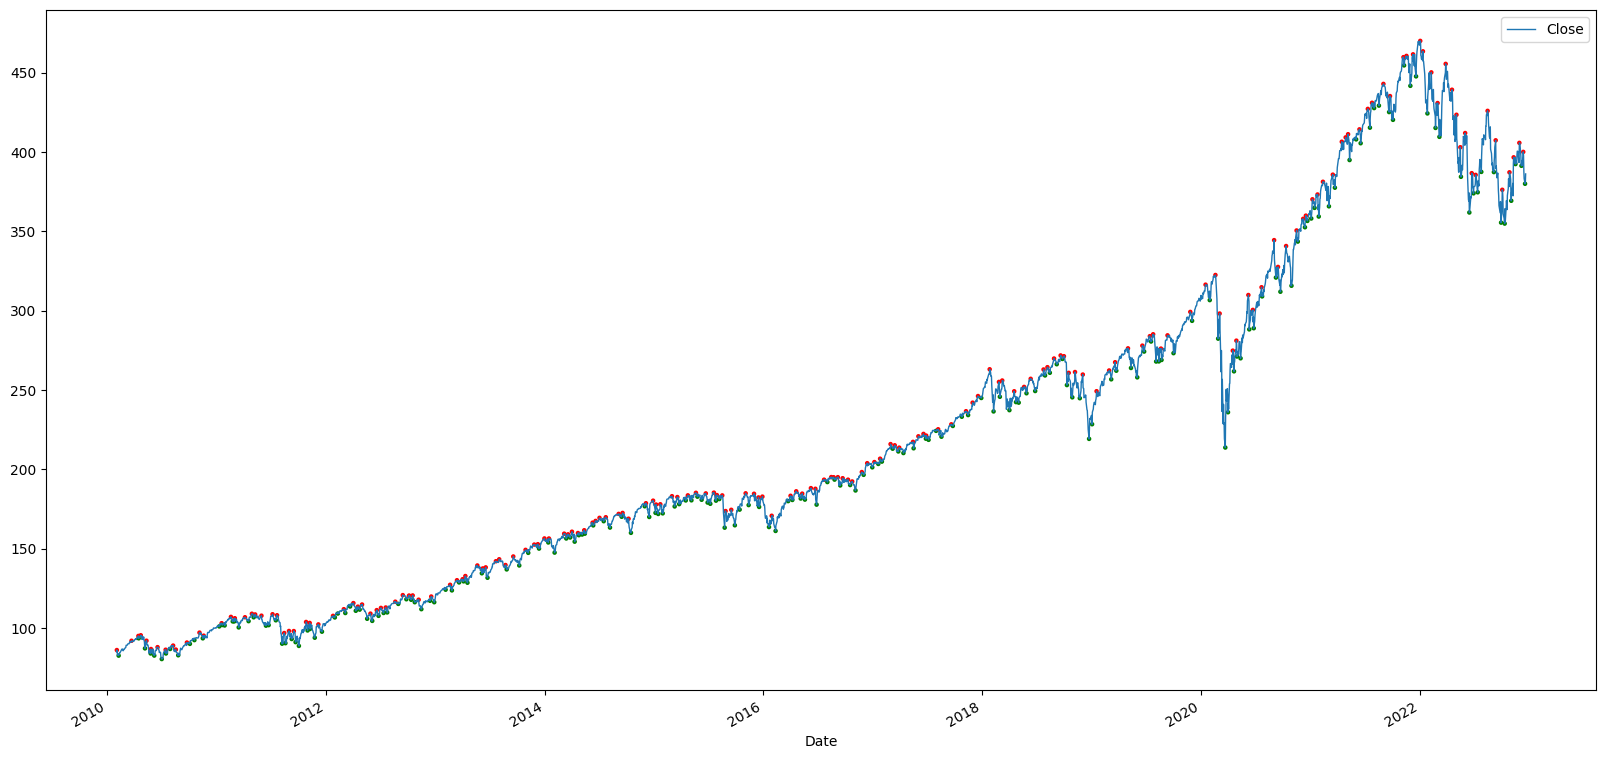

In [29]:
rcParams['figure.figsize'] = 20, 10
plt.figure(figsize=(50, 30))
prices_and_indicators_with_label[["Close"]].plot(kind="line", stacked=False,linewidth=1)
buy_and_sell_preds = prices_and_indicators_with_label.query('Label != 0')
plt.scatter(x = buy_and_sell_preds.index, y = buy_and_sell_preds.Close, s=5, c=pltcolor(buy_and_sell_preds.Label))
plt.show() 

In [30]:
prices_and_indicators_with_label.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3247 entries, 2010-02-01 00:00:00-05:00 to 2022-12-21 00:00:00-05:00
Columns: 678 entries, Open to Label
dtypes: float64(676), int64(2)
memory usage: 16.8 MB


In [31]:
datas = []

for i in range(5, 13):
    train = prices_and_indicators_with_label.loc[ (prices_and_indicators_with_label.index >= f"{2010+i-5}") & (prices_and_indicators_with_label.index <= f"{2010+i}") ]
    test = prices_and_indicators_with_label.loc[ (prices_and_indicators_with_label.index >= f"{2010+i}") & (prices_and_indicators_with_label.index <= f"{2010+i+1}") ]
    datas.append([train, test])

In [32]:
for i in range(len(datas)):
    selected_feature_count = 30
    select = SelectKBest(score_func=f_classif, k = selected_feature_count)
    fitted = select.fit(datas[i][0].iloc[:,:-1], datas[i][0].iloc[:,-1])
    train_features = fitted.transform(datas[i][0].iloc[:,:-1])
    test_features = fitted.transform(datas[i][1].iloc[:,:-1])
    
    selected_features_boolean = select.get_support()
    features = list(datas[i][1].columns[:-1])
    selected_features = []
    for j in range(len(features)):
        if selected_features_boolean[j]:
            selected_features.append(features[j])
    train_label = datas[i][0].Label
    test_label = datas[i][1].Label
    
    datas[i][0] = pd.DataFrame(data=train_features.astype('float32'), columns=selected_features, index=datas[i][0].index)
    datas[i][0]["Label"] = train_label
    datas[i][1] = pd.DataFrame(data=test_features.astype('float32'), columns=selected_features, index=datas[i][1].index)
    datas[i][1]["Label"] = test_label

In [34]:
datas[0][0]

,WILLR-7,STOCHF-7,STOCHRSI-7,CCI-7,WILLR-8,STOCHF-8,STOCHRSI-8,STOCHF-9,STOCHRSI-9,STOCHF-10,STOCHRSI-10,STOCHRSI-11,STOCHRSI-12,STOCHRSI-13,STOCHRSI-14,STOCHRSI-15,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-01 00:00:00-05:00,-59.291996,56.615494,100.000000,-76.258041,-73.900642,56.615494,100.000000,40.708004,100.000000,26.099361,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.428474,96.802124,94.430870,92.297562,90.348633,88.584419,86.994080,85.519051,84.193413,83.005699,81.931206,80.996941,80.084663,0
2010-02-02 00:00:00-05:00,-6.231406,93.768593,100.000000,86.250259,-30.088423,93.768593,100.000000,93.768593,100.000000,69.911575,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,2
2010-02-03 00:00:00-05:00,-22.552691,77.447311,86.058510,82.485535,-22.552691,77.447311,86.356758,77.447311,86.477226,77.447311,86.484680,86.418251,86.302773,86.154907,85.985764,85.803154,85.612701,85.419067,85.222298,85.025848,84.833336,84.642624,84.457817,84.281105,84.106781,83.942650,83.789574,83.645798,83.517807,83.386322,0
2010-02-04 00:00:00-05:00,-99.520287,0.479715,25.313549,-138.423447,-99.520287,0.479715,24.801561,0.479715,23.799667,0.479715,22.472393,20.929407,19.245783,17.476149,15.658271,13.820140,11.983085,10.166849,8.364130,6.592392,4.870477,3.182296,1.551989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2010-02-05 00:00:00-05:00,-65.391174,34.608829,9.173374,-147.629913,-65.391174,34.608829,9.075439,34.608829,8.948235,34.608829,8.803155,8.648961,8.491790,8.335863,8.183775,8.037127,7.896864,7.763718,7.636597,7.516041,7.402761,7.295138,7.194220,7.100290,7.010635,6.927838,6.851749,6.781305,6.718542,6.656283,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24 00:00:00-05:00,-26.825228,55.212425,100.000000,61.014713,-26.825228,72.389053,100.000000,73.174774,100.000000,73.174774,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0
2014-12-26 00:00:00-05:00,-23.021166,87.345642,100.000000,76.803001,-22.366060,62.657482,100.000000,76.978836,100.000000,77.633942,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,0
2014-12-29 00:00:00-05:00,-34.232105,90.039764,100.000000,96.051414,-21.103638,92.559448,100.000000,65.767891,100.000000,78.896362,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,2


In [35]:
datas[0][1]

,WILLR-7,STOCHF-7,STOCHRSI-7,CCI-7,WILLR-8,STOCHF-8,STOCHRSI-8,STOCHF-9,STOCHRSI-9,STOCHF-10,STOCHRSI-10,STOCHRSI-11,STOCHRSI-12,STOCHRSI-13,STOCHRSI-14,STOCHRSI-15,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,-7.390419e+01,26.095810,0.000000,-149.176270,-7.390419e+01,26.095810,0.000000,26.095810,0.000000,26.095810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-05 00:00:00-05:00,-9.514440e+01,4.855598,0.000000,-168.912704,-9.514440e+01,4.855598,0.000000,4.855598,0.000000,4.855598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-06 00:00:00-05:00,-9.050440e+01,10.094645,0.000000,-141.480423,-9.050440e+01,9.495598,0.000000,9.495598,0.000000,9.495598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2015-01-07 00:00:00-05:00,-6.587525e+01,36.977566,71.096405,-69.489861,-6.587525e+01,36.277569,65.546577,34.124748,61.592785,34.124748,58.587921,56.196621,54.230564,52.576454,51.161705,49.937057,48.867329,47.926266,47.093575,46.353119,45.691788,45.098770,44.565029,44.082939,43.646030,43.248783,42.886448,42.554947,42.250748,41.970795,0
2015-01-08 00:00:00-05:00,-2.597348e+01,87.780235,100.000000,31.489433,-3.036644e+01,75.454910,100.000000,74.026527,100.000000,69.633560,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.499054,98.899155,98.352303,97.852386,97.394104,2
2015-01-09 00:00:00-05:00,-4.222908e+01,71.296478,78.046242,31.450287,-4.332270e+01,67.207619,77.761581,57.770916,77.430458,56.677296,77.080338,76.723671,76.367233,76.015541,75.671898,75.338837,75.018181,74.711197,74.418633,74.140846,73.877823,73.629311,73.394867,73.173904,72.965752,72.769707,72.585014,72.410942,72.246765,72.091782,0
2015-01-12 00:00:00-05:00,-5.274304e+01,50.132042,58.945229,-13.073448,-5.937844e+01,50.132042,58.263466,47.256962,57.515903,40.621559,56.748413,55.980350,55.221691,54.478931,53.756962,53.059566,52.389557,51.748837,51.138496,50.558918,50.009899,49.490784,49.000580,48.538059,48.101837,47.690437,47.302353,46.936089,46.590176,46.263199,0
2015-01-13 00:00:00-05:00,-5.740758e+01,26.565065,3.518930,-14.999607,-5.985026e+01,42.592422,3.778024,42.592422,3.501540,40.149742,2.918442,2.149653,1.267419,0.319405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2015-01-14 00:00:00-05:00,-7.082807e+01,29.171930,0.000000,-108.418694,-7.082807e+01,29.171930,0.000000,29.171930,0.000000,29.171930,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0


In [38]:
for i in range(len(datas)):
    abs_scaler = MaxAbsScaler()
    abs_scaler.fit(datas[i][0])
    scaled_train = abs_scaler.transform(datas[i][0])
    scaled_test = abs_scaler.transform(datas[i][1])
    datas[i][0] = pd.DataFrame(data=scaled_train, columns=datas[i][0].columns, index=datas[i][0].index)
    datas[i][0]["Label"] = datas[i][0]["Label"] * 2
    datas[i][1] = pd.DataFrame(data=scaled_test, columns=datas[i][1].columns, index=datas[i][1].index)
    datas[i][1]["Label"] = datas[i][1]["Label"] * 2

In [42]:
datas[0][0]

,WILLR-7,STOCHF-7,STOCHRSI-7,CCI-7,WILLR-8,STOCHF-8,STOCHRSI-8,STOCHF-9,STOCHRSI-9,STOCHF-10,STOCHRSI-10,STOCHRSI-11,STOCHRSI-12,STOCHRSI-13,STOCHRSI-14,STOCHRSI-15,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-02-01 00:00:00-05:00,-0.592920,0.566155,1.000000,-0.326820,-0.739006,0.566155,1.000000,0.407080,1.000000,0.260994,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.994285,0.968021,0.944309,0.922976,0.903486,0.885844,0.869941,0.855191,0.841934,0.830057,0.819312,0.809969,0.800847,0.0
2010-02-02 00:00:00-05:00,-0.062314,0.937686,1.000000,0.369644,-0.300884,0.937686,1.000000,0.937686,1.000000,0.699116,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2010-02-03 00:00:00-05:00,-0.225527,0.774473,0.860585,0.353509,-0.225527,0.774473,0.863568,0.774473,0.864772,0.774473,0.864847,0.864183,0.863028,0.861549,0.859858,0.858032,0.856127,0.854191,0.852223,0.850258,0.848333,0.846426,0.844578,0.842811,0.841068,0.839426,0.837896,0.836458,0.835178,0.833863,0.0
2010-02-04 00:00:00-05:00,-0.995203,0.004797,0.253135,-0.593243,-0.995203,0.004797,0.248016,0.004797,0.237997,0.004797,0.224724,0.209294,0.192458,0.174761,0.156583,0.138201,0.119831,0.101668,0.083641,0.065924,0.048705,0.031823,0.015520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2010-02-05 00:00:00-05:00,-0.653912,0.346088,0.091734,-0.632700,-0.653912,0.346088,0.090754,0.346088,0.089482,0.346088,0.088032,0.086490,0.084918,0.083359,0.081838,0.080371,0.078969,0.077637,0.076366,0.075160,0.074028,0.072951,0.071942,0.071003,0.070106,0.069278,0.068517,0.067813,0.067185,0.066563,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24 00:00:00-05:00,-0.268252,0.552124,1.000000,0.261492,-0.268252,0.723891,1.000000,0.731748,1.000000,0.731748,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
2014-12-26 00:00:00-05:00,-0.230212,0.873456,1.000000,0.329156,-0.223661,0.626575,1.000000,0.769788,1.000000,0.776339,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
2014-12-29 00:00:00-05:00,-0.342321,0.900398,1.000000,0.411649,-0.211036,0.925594,1.000000,0.657679,1.000000,0.788964,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [40]:
datas[0][1]

,WILLR-7,STOCHF-7,STOCHRSI-7,CCI-7,WILLR-8,STOCHF-8,STOCHRSI-8,STOCHF-9,STOCHRSI-9,STOCHF-10,STOCHRSI-10,STOCHRSI-11,STOCHRSI-12,STOCHRSI-13,STOCHRSI-14,STOCHRSI-15,STOCHRSI-16,STOCHRSI-17,STOCHRSI-18,STOCHRSI-19,STOCHRSI-20,STOCHRSI-21,STOCHRSI-22,STOCHRSI-23,STOCHRSI-24,STOCHRSI-25,STOCHRSI-26,STOCHRSI-27,STOCHRSI-28,STOCHRSI-29,Label
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02 00:00:00-05:00,-7.390419e-01,0.260958,0.000000,-0.639327,-7.390419e-01,0.260958,0.000000,0.260958,0.000000,0.260958,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-05 00:00:00-05:00,-9.514440e-01,0.048556,0.000000,-0.723912,-9.514440e-01,0.048556,0.000000,0.048556,0.000000,0.048556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-06 00:00:00-05:00,-9.050440e-01,0.100946,0.000000,-0.606345,-9.050440e-01,0.094956,0.000000,0.094956,0.000000,0.094956,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5
2015-01-07 00:00:00-05:00,-6.587525e-01,0.369776,0.710964,-0.297814,-6.587525e-01,0.362776,0.655466,0.341247,0.615928,0.341247,0.585879,0.561966,0.542306,0.525765,0.511617,0.499371,0.488673,0.479263,0.470936,0.463531,0.456918,0.450988,0.445650,0.440829,0.436460,0.432488,0.428864,0.425549,0.422507,0.419708,0.0
2015-01-08 00:00:00-05:00,-2.597348e-01,0.877802,1.000000,0.134955,-3.036644e-01,0.754549,1.000000,0.740265,1.000000,0.696336,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.994991,0.988992,0.983523,0.978524,0.973941,1.0
2015-01-09 00:00:00-05:00,-4.222908e-01,0.712965,0.780462,0.134787,-4.332270e-01,0.672076,0.777616,0.577709,0.774305,0.566773,0.770803,0.767237,0.763672,0.760155,0.756719,0.753388,0.750182,0.747112,0.744186,0.741408,0.738778,0.736293,0.733949,0.731739,0.729658,0.727697,0.725850,0.724109,0.722468,0.720918,0.0
2015-01-12 00:00:00-05:00,-5.274304e-01,0.501320,0.589452,-0.056029,-5.937844e-01,0.501320,0.582635,0.472570,0.575159,0.406216,0.567484,0.559804,0.552217,0.544789,0.537570,0.530596,0.523896,0.517488,0.511385,0.505589,0.500099,0.494908,0.490006,0.485381,0.481018,0.476904,0.473024,0.469361,0.465902,0.462632,0.0
2015-01-13 00:00:00-05:00,-5.740758e-01,0.265651,0.035189,-0.064284,-5.985026e-01,0.425924,0.037780,0.425924,0.035015,0.401497,0.029184,0.021497,0.012674,0.003194,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2015-01-14 00:00:00-05:00,-7.082807e-01,0.291719,0.000000,-0.464652,-7.082807e-01,0.291719,0.000000,0.291719,0.000000,0.291719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [41]:
total_na_count = 0
for data in datas:
    total_na_count += number_null_and_nan(data[0])
    total_na_count += number_null_and_nan(data[1])
print(f"Total null and nan values = {total_na_count}")

Total null and nan values = 0


In [53]:
def create_model_MLP(trial=None,activation_func="swish", dropout_rate = 0.2, optimizer_algo = "adam"):
    MLP = Sequential()
    MLP.add(Dense(64, input_shape=(30,), activation=activation_func, kernel_initializer=tf.keras.initializers.HeUniform()))
    MLP.add(BatchNormalization())
    MLP.add(Dense(32, activation=activation_func))
    MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(32, activation=activation_func))
    MLP.add(Dropout(dropout_rate))
    MLP.add(Dense(3, activation='softmax'))
    MLP.compile(loss="categorical_crossentropy", optimizer=optimizer_algo, metrics=["accuracy","Precision","Recall","AUC",tfa.metrics.F1Score(num_classes=3, average="macro")])
    return MLP

In [73]:
start_time = time.time()
histories=[]

for i in range(len(datas)):
    OUTPUT_PATH = "./outputs"
    es = EarlyStopping(monitor='val_f1_score', mode='max', verbose=1, patience=50, min_delta=1e-2)
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,f"best_CNN_model-{i+1}.h5"), monitor='val_f1_score', verbose=0, 
                          save_best_only=True, save_weights_only=False, mode='max', save_freq=1)
    
    val_split_point = int(0.5*len(datas[i][0]))
    X_train = datas[i][0][:val_split_point].iloc[:, :-1]
    y_train = tf.keras.utils.to_categorical(datas[i][0][:val_split_point].iloc[:, -1], num_classes = 3)
    X_val = datas[i][0][val_split_point:].iloc[:, :-1]
    y_val = tf.keras.utils.to_categorical(datas[i][0][val_split_point:].iloc[:, -1], num_classes = 3)
    
    model = create_model_MLP()
    model.fit(X_train, y_train, batch_size=64, 
                        epochs=50, verbose=0, callbacks=[es, mcp], 
                        validation_data=(X_val, y_val), 
                        class_weight={0:1, 1:10, 2:10})
    
minutes = round(int(time.time() - start_time)/60, 2)
print(f"\nCompleted in {minutes} minutes\n")


Completed in 1.28 minutes

